# KNN Tierlist: Ranking Champions from Individual League Patches

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
import warnings
import os
warnings.filterwarnings("ignore", category=UserWarning)

## Importing the CSVs into data files.
For my training and test data, I used the data I scraped from Lolayltics, which came with champion rankings. This allows me to train my model with a set of discrete, numerical classes in order to populate the groups for KNN decision making. The best rank is 1, and as it increases, it indicates a weaker character strength. So, rank 171 would be the worst character in the patch.

In [2]:
patch_list = []
patches = list(range(13,20))
patches.extend(list(range(21,25)))
for patch in patches:
    print(patch, end = ' ')
    patch_list.append(pd.read_csv(f"../datasets/lol_patch_tierlist/lolpatch_15.{patch}.csv"))
train = pd.concat(patch_list)

13 14 15 16 17 18 19 21 22 23 24 

In [3]:
# Four features from datascraping: win-rate, pick-rate, ban-rate, and rank. 
# The Patch and Champion columns are not used by my model.
train

,patch,champion,win_rate,pick_rate,ban_rate,rank
0,15.13,Urgot,51.87,3.05,1.64,1
1,15.13,Nami,52.15,8.82,2.16,2
2,15.13,Soraka,51.69,4.32,2.08,3
3,15.13,Kog'Maw,52.39,1.76,0.74,4
4,15.13,Ekko,50.47,4.71,3.02,5
...,...,...,...,...,...,...
166,15.24,Gragas,47.63,1.58,0.53,167
167,15.24,Yone,48.95,7.29,5.84,168
168,15.24,Aurora,48.15,2.21,2.22,169
169,15.24,Annie,49.43,1.23,0.51,170


In [4]:
patch_list = []
for patch in [20]:
    print(patch, end = ' ')
    patch_list.append(pd.read_csv(f"../datasets/lol_patch_tierlist/lolpatch_15.{patch}.csv"))
test = pd.concat(patch_list)

20 

## Testing KNN Parameters

For this section, I perform tests in order to get more accurate KNN models. This involves testing a range of neighbors for my KNN model, and checking the score function, which is a percentage of how many times a record is labelled correctly by the KNN model. I also test two different types of normalization: min-max normalization and z-score normalization.

In [5]:
X = np.column_stack([train["win_rate"],train["pick_rate"],train["ban_rate"]])
c = train["rank"]

X_test = np.column_stack([test["win_rate"],test["pick_rate"],test["ban_rate"]])
c_test = test["rank"]

In [6]:
last_value = 0
for i in range(1,30,2):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X, c)
    accuracy = knn.score(X_test, c_test)
    if (last_value != accuracy):
        print(f"{i} Neighbors: {accuracy}")
        last_value = accuracy

1 Neighbors: 0.023391812865497075
3 Neighbors: 0.04093567251461988
7 Neighbors: 0.05263157894736842
9 Neighbors: 0.04678362573099415
13 Neighbors: 0.03508771929824561
19 Neighbors: 0.04093567251461988
25 Neighbors: 0.03508771929824561
29 Neighbors: 0.029239766081871343


In [7]:
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X, c)
knn.score(X_test, c_test)

0.05263157894736842

In [8]:
def minmax(df_col):
    #min max normalization
    return (df_col - df_col.min())/(df_col.max() - df_col.min())

X_minmax = np.column_stack([minmax(train["win_rate"]),minmax(train["pick_rate"]),minmax(train["ban_rate"])])
X_test_minmax = np.column_stack([minmax(test["win_rate"]),minmax(test["pick_rate"]),minmax(test["ban_rate"])])

In [9]:
def meanstd(df_col):
    #minus every data point by mean, then divide by standard deviation
    return (df_col-df_col.mean()) - df_col.std()

X_meanstd = np.column_stack([meanstd(train["win_rate"]),meanstd(train["pick_rate"]),meanstd(train["ban_rate"])])
X_test_meanstd = np.column_stack([meanstd(test["win_rate"]),meanstd(test["pick_rate"]),meanstd(test["ban_rate"])])

In [10]:
def accuracy_test(train, test):
    acc_dict = {'neighbors':[],
               'accuracy':[]}
    neighbor = 0
    max_accuracy = 0
    for i in range(1,30,2):
        knn = KNeighborsClassifier(n_neighbors=i)
        knn.fit(train, c)
        accuracy = knn.score(test, c_test)
        acc_dict['neighbors'].append(i)
        acc_dict['accuracy'].append(accuracy)
        if accuracy > max_accuracy:
            max_accuracy = accuracy
            neighbor = i
    print(f"Max Accuracy | Neighbors")
    print(f"{max_accuracy} | {neighbor}")
    return acc_dict

In [11]:
meanstd_scores = accuracy_test(X_meanstd, X_test_meanstd)

Max Accuracy | Neighbors
0.04678362573099415 | 3


In [12]:
minmax_scores = accuracy_test(X_minmax, X_test_minmax)

Max Accuracy | Neighbors
0.03508771929824561 | 19


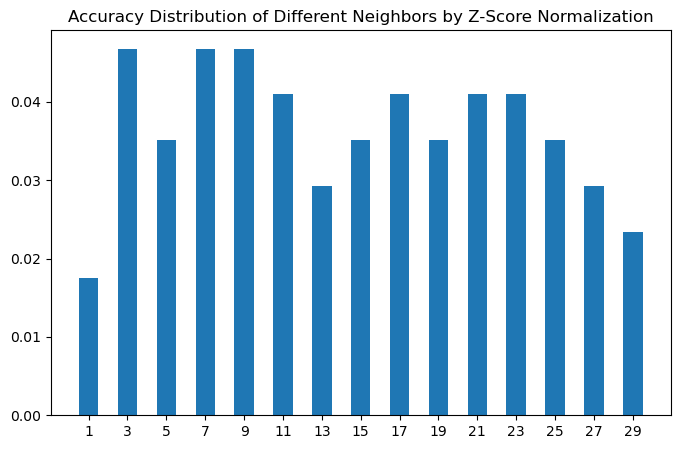

In [13]:
plt.figure(figsize=(8,5))
plt.bar(x = meanstd_scores['neighbors'], height = meanstd_scores['accuracy'], width = 1)
plt.title('Accuracy Distribution of Different Neighbors by Z-Score Normalization')
plt.xticks(ticks = meanstd_scores['neighbors']);

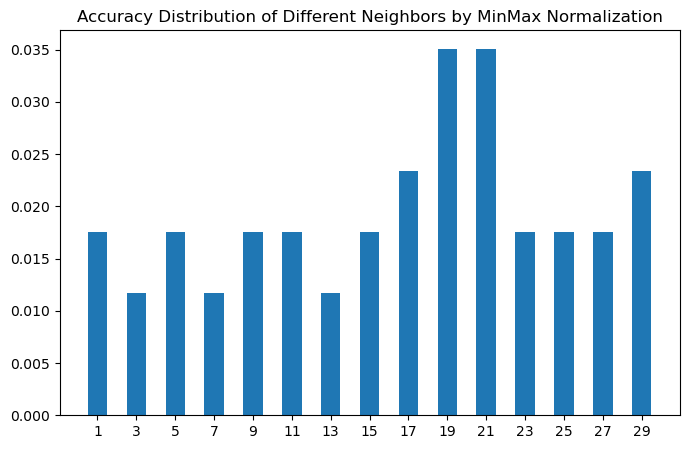

In [14]:
plt.figure(figsize=(8,5))
plt.bar(x = minmax_scores['neighbors'], height = minmax_scores['accuracy'], width = 1)
plt.title('Accuracy Distribution of Different Neighbors by MinMax Normalization')
plt.xticks(ticks = minmax_scores['neighbors']);

## Final Model 
Due to the testing of various normalizations and neighbors, I chose to use a KNN model that predicts off the seven nearest neighbors and trains off z-score normalized data. Although it is trained off the Lolayltics data, which includes a ranking, the model will be predicting off the data that Brandon scraped from the Riot API.

Three different neighbors from z-score normalization all produced a peak score of around 0.047: 3, 7, and 9 neighbors. Earlier I managed to score a high higher score of 0.52 without normalizing the data. While it may seem better to not normalize the data because of this, Brandon's samples from the Riot API have a much higher variance. Win rates can span from 0 to 100% because of the lower sample sizes. Therefore, it is best to normalize data in the model training in order to prepare the model for a higher accuracy on the Riot API data. Having a slightly lower score now will produce more accurate results when it comes to using the model in production.

In [15]:
lolKnn = KNeighborsClassifier(n_neighbors=7)
lolKnn.fit(X_meanstd, c)

,n_neighbors,7
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


# Applying the model to the Riot API data
In this part, I do two steps:
1. Transform Brandon's csvs into pandas dataframes


   This was done just by searching for the champion win rate csvs in each of the "riot_out" folders.
     
3. Apply rankings to each champion.


   This was done by using an apply function to add my KNN models prediction of the win/pick/ban rate data to a rank column. 


In [16]:
patch_list = []
for patch in range(1,21):
    for i in os.listdir(f"../datasets/riot_out/patch_15.{patch}"):
        if 'champion' in i: 
            winratecsv = i
    print(f"../datasets/riot_out/patch_15.{patch}/" + winratecsv)
    temp_df = pd.read_csv(f"../datasets/riot_out/patch_15.{patch}/" + winratecsv)
    temp_df["patch"] = f"15.{patch}"
    patch_list.append(temp_df)
# creates a list of patches, patch list, by iterating through the different folders and searching for the champion win_rates. 

df = pd.concat(patch_list)

../datasets/riot_out/patch_15.1/champion_winrates_15.1_20251119-032215.csv
../datasets/riot_out/patch_15.2/champion_winrates_15.2_20251119-035231.csv
../datasets/riot_out/patch_15.3/champion_winrates_15.3_20251119-042249.csv
../datasets/riot_out/patch_15.4/champion_winrates_15.4_20251119-045306.csv
../datasets/riot_out/patch_15.5/champion_winrates_15.5_20251119-052323.csv
../datasets/riot_out/patch_15.6/champion_winrates_15.6_20251119-055337.csv
../datasets/riot_out/patch_15.7/champion_winrates_15.7_20251119-062353.csv
../datasets/riot_out/patch_15.8/champion_winrates_15.8_20251119-065409.csv
../datasets/riot_out/patch_15.9/champion_winrates_15.9_20251119-072426.csv
../datasets/riot_out/patch_15.10/champion_winrates_15.10_20251119-075442.csv
../datasets/riot_out/patch_15.11/champion_winrates_15.11_20251119-082459.csv
../datasets/riot_out/patch_15.12/champion_winrates_15.12_20251119-085514.csv
../datasets/riot_out/patch_15.13/champion_winrates_15.13_20251119-092533.csv
../datasets/riot_

In [17]:
df

,patch,championId,championName,games,wins,win_rate,pick_rate,ban_rate
0,15.1,89,Leona,10,3,30.00,37.037,3.704
1,15.1,21,MissFortune,9,5,55.56,33.333,14.815
2,15.1,51,Caitlyn,6,0,0.00,22.222,29.630
3,15.1,35,Shaco,6,2,33.33,22.222,37.037
4,15.1,39,Irelia,5,2,40.00,18.519,22.222
...,...,...,...,...,...,...,...,...
166,15.20,154,Zac,3,1,33.33,1.224,1.600
167,15.20,429,Kalista,2,1,50.00,0.816,0.000
168,15.20,57,Maokai,2,0,0.00,0.816,0.000
169,15.20,72,Skarner,2,1,50.00,0.816,0.400


In [18]:
# Only predicts rankings for patch 25.20.
patch = patch_list[19]
def dfPredict(row):
    wr_norm = (row["win_rate"]-patch["win_rate"].mean())/patch["win_rate"].std()
    pr_norm = (row["pick_rate"]-patch["pick_rate"].mean())/patch["pick_rate"].std()
    br_norm = (row["ban_rate"]-patch["ban_rate"].mean())/patch["ban_rate"].std()
    # print(wr_norm,pr_norm,br_norm) # for debug
    prediction = lolKnn.predict(np.column_stack([wr_norm,pr_norm,br_norm]))
    return(prediction[0])
patch["rank"] = patch.apply(dfPredict,axis=1)

In [19]:
patch.head(10)

,patch,championId,championName,games,wins,win_rate,pick_rate,ban_rate,rank
0,15.20,266,Aatrox,10,5,50.0,4.082,9.2,5
1,15.20,103,Ahri,10,5,50.0,4.082,3.6,5
2,15.20,84,Akali,10,4,40.0,4.082,9.6,8
3,15.20,166,Akshan,10,3,30.0,4.082,5.6,79
4,15.20,12,Alistar,10,4,40.0,4.082,2.4,5
5,15.20,799,Ambessa,10,8,80.0,4.082,12.4,9
6,15.20,32,Amumu,10,5,50.0,4.082,5.2,5
7,15.20,34,Anivia,10,6,60.0,4.082,3.2,5
8,15.20,523,Aphelios,10,3,30.0,4.082,2.0,79
9,15.20,22,Ashe,10,5,50.0,4.082,7.6,5


In [20]:
# results of predicting for patch 15.20 of the riot api data.
patch.sort_values("rank")

,patch,championId,championName,games,wins,win_rate,pick_rate,ban_rate,rank
141,15.20,350,Yuumi,7,5,71.43,2.857,6.4,1
128,15.20,895,Nilah,8,6,75.00,3.265,2.8,1
60,15.20,950,Naafiri,10,8,80.00,4.082,5.2,2
161,15.20,133,Quinn,4,2,50.00,1.633,6.0,2
7,15.20,34,Anivia,10,6,60.00,4.082,3.2,5
...,...,...,...,...,...,...,...,...,...
139,15.20,360,Samira,7,2,28.57,2.857,5.2,84
31,15.20,39,Irelia,10,2,20.00,4.082,10.8,92
163,15.20,200,Belveth,3,1,33.33,1.224,15.2,96
158,15.20,83,Yorick,5,1,20.00,2.041,12.0,96


In [21]:
# export to the csv for the final notebook.
patch.to_csv("../Datasets/lol_patch_tierlist/knnrank_15.20.csv", index=False)

In [22]:
# export multiple csvs for every patch brandon collected
k = 1
for patch in patch_list:
    patch["rank"] = patch.apply(dfPredict,axis=1)
    patch.to_csv(f"../Datasets/lol_patch_tierlist/knnrank_15.{k}.csv", index=False)
    print(k)
    k+=1

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
